<a href="https://colab.research.google.com/github/dksifoua/Variational-AutoEncoder/blob/master/CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [0]:
def vlb_binomial(x, x_decoded_mean, t_mean, t_log_var):
    """
    :params
        x: Tensor[batch_size, n_pixels]
            Matrix with one image per row with zeros and ones
        x_decoded_mean: Tensor[batch_size, n_pixels]
            Distribution p(x | t), real numbers from 0 to 1
        t_mean: Tensor[batch_size, latent_dim]
            Mean vector of the (normal) distribution q(t | x)
        t_log_var: Tensor[batch_size, latent_dim]

    :return
        Tensor[]
    """
    reconstructed_loss = tf.reduce_mean(-tf.reduce_sum(x * tf.math.log(x_decoded_mean + 1e-10) + (1 - x) * tf.math.log(1 - x_decoded_mean + 1e-10), axis=1))
    KL = tf.reduce_mean(tf.reduce_sum((-t_log_var + tf.math.exp(t_log_var) + t_mean**2 - 1) / 2, axis=1))
    return reconstructed_loss + KL

In [0]:
class Encoder(tf.keras.Model):

    def __init__(self, intermediate_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = tf.keras.layers.Dense(intermediate_dim, activation=tf.nn.relu)
        self.fc2 = tf.keras.layers.Dense(intermediate_dim // 2, activation=tf.nn.relu)
        self.fc3 = tf.keras.layers.Dense(latent_dim * 2)

        self.get_t_mean = tf.keras.layers.Lambda(lambda latent: latent[:, :latent_dim])
        self.get_t_log_var = tf.keras.layers.Lambda(lambda latent: latent[:, latent_dim:])

    def call(self, inputs):
        """
        :params
            inputs: Tensor[batch_size, original_dim]

        :return
            t_mean: Tensor[batch_size, latent_dim]
            t_log_var: Tensor[batch_size, latent_dim]
        """
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)
        t_mean = self.get_t_mean(x)
        t_log_var = self.get_t_log_var(x)
        return t_mean, t_log_var

In [0]:
class Decoder(tf.keras.Model):

    def __init__(self, intermediate_dim, original_dim):
        super(Decoder, self).__init__()
        self.fc1 = tf.keras.layers.Dense(intermediate_dim // 2, activation=tf.nn.relu)
        self.fc2 = tf.keras.layers.Dense(intermediate_dim, activation=tf.nn.relu)
        self.fc3 = tf.keras.layers.Dense(original_dim, activation=tf.nn.sigmoid)

    def call(self, inputs):
        """
        :params
            inputs: Tensor[batch_size, latent_dim]

        :return
            Tensor[batch_size, original_dim]
        """
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [0]:
class CVAE(tf.keras.Model):

    def __init__(self, encoder, decoder):
        super(CVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def sample(self, t_mean, t_log_var):
        """
        Sampling from the distribution q(t | x) = N(t_mean, exp(t_log_var)) with reparametrization trick.
        :params
            t_mean: Tensor[batch_size, latent_dim]
            t_log_var: Tensor[batch_size, latent_dim]
        
        :return
            Tensor[batch_size, latent_dim]
        """
        s_i = tf.exp(t_log_var * 0.5)
        epsilon_i = tf.random.normal(tf.shape(t_mean), mean=0, stddev=1)
        res = t_mean + s_i * epsilon_i
        return res

    def call(self, inputs, labels):
        """
        :params
            inputs: Tensor[batch_size, latent_dim]
            labels: Tensor[batch_size, label_size]

        :return
            decoded_mean[batch_size, original_dim]
            t_mean: Tensor[batch_size, latent_dim]
            t_log_var: Tensor[batch_size, latent_dim]
        """
        t_mean, t_log_var = self.encoder(tf.concat([inputs, labels], axis=1))
        samples = self.sample(t_mean, t_log_var)
        decoded_mean = self.decoder(tf.concat([samples, labels], axis=1))
        return decoded_mean, t_mean, t_log_var

In [0]:
@tf.function
def train_step(model, optimizer, loss_func, data, labels):
    """Pass through a batch"""
    with tf.GradientTape() as tape:
        decoded_mean, t_mean, t_log_var = model(data, labels)
        loss = loss_func(data, decoded_mean, t_mean, t_log_var)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function
def valid_step(model, loss_func, data, labels):
    """Pass through a batch"""
    decoded_mean, t_mean, t_log_var = model(data, labels)
    loss = loss_func(data, decoded_mean, t_mean, t_log_var)
    return loss

In [0]:
def train(model, optimizer, loss_function, train_data, valid_data, n_epochs, batch_size):
    assert callable(loss_function)

    history = {'loss': [], 'val_loss': []}
    train_data = train_data.shuffle(1000)
    train_data = train_data.batch(batch_size)
    train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)
    
    valid_data = valid_data.batch(batch_size)
    valid_data = valid_data.prefetch(tf.data.experimental.AUTOTUNE)
    
    best_loss = [float('inf')]
    n_batches_per_epoch = (len(x_train) // batch_size) + (len(x_train) % batch_size) # Global variable
    n_valid_batches = (len(x_test) // batch_size) + (len(x_test) % batch_size) # Global variable
    for epoch in range(n_epochs):
        epoch_text = f'Epoch: {epoch + 1:02d} - '
        
        # Training
        loss = 0.
        train_pbar = tqdm.tqdm(enumerate(train_data), total=n_batches_per_epoch)
        for i, data in train_pbar:
            loss += train_step(model, optimizer, loss_function, data[0], data[1])
            train_pbar.set_description(epoch_text + f'loss:     {loss.numpy()/(i+1):.3f}')
        history['loss'].append(loss.numpy() / n_batches_per_epoch)
            
        # Validation
        val_loss = 0.
        val_pbar = tqdm.tqdm(enumerate(valid_data), total=n_valid_batches)
        for i, data in val_pbar:
            val_loss += valid_step(model, loss_function, data[0], data[1])
            val_pbar.set_description(epoch_text + f'val_loss: {val_loss.numpy()/(i+1):.3f}')
        history['val_loss'].append(val_loss.numpy() / n_valid_batches)
            
        # Stop training if degrading
        try:
            if history['val_loss'][-1] > best_loss[-2]:
                print('Stop training because the loss is increasing!')
                break
        except IndexError:
            pass
    print()
        
    return history

In [0]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# One hot encoding.
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [0]:
LABEL_SIZE = 10

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [0]:
BATCH_SIZE = 100
ORIGINAL_DIM = 784
LATENT_DIM = 3
INTERMEDIATE_DIM = 256
N_EPOCHS = 20

In [0]:
tf.keras.backend.clear_session()
encoder = Encoder(intermediate_dim=INTERMEDIATE_DIM, latent_dim=LATENT_DIM)
decoder = Decoder(intermediate_dim=INTERMEDIATE_DIM, original_dim=ORIGINAL_DIM)
cvae_model = CVAE(encoder=encoder, decoder=decoder)
optimizer = tf.optimizers.RMSprop(learning_rate=1e-3)

In [12]:
%%time
history = train(model=cvae_model,
                optimizer=optimizer,
                loss_function=vlb_binomial,
                train_data=train_dataset,
                valid_data=test_dataset,
                n_epochs=N_EPOCHS,
                batch_size=BATCH_SIZE)

Epoch: 20 - val_loss: 122.138: 100%|██████████| 100/100 [00:00<00:00, 147.76it/s]


CPU times: user 4min 19s, sys: 34.7 s, total: 4min 54s
Wall time: 3min 27s


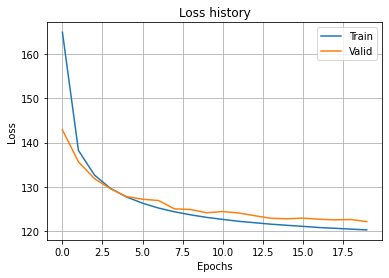

In [13]:
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Valid')
plt.title('Loss history')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

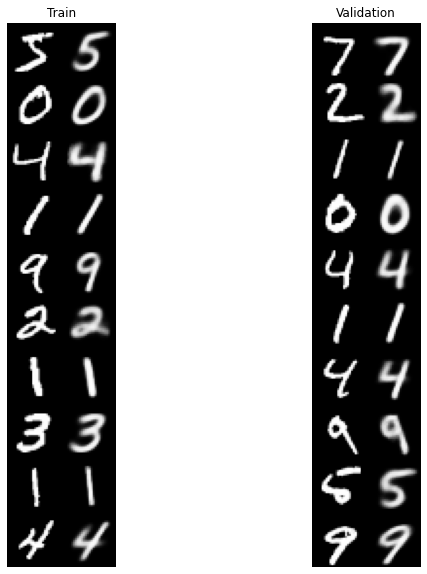

In [14]:
fig = plt.figure(figsize=(10, 10))
for fid_idx, (x_data, y_data, title) in enumerate(
            zip([x_train, x_test], [y_train, y_test], ['Train', 'Validation'])):
    n = 10  # figure with 10 x 2 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * 2))
    decoded, _, _ = cvae_model(tf.convert_to_tensor(x_data[:BATCH_SIZE, :]),
                               tf.convert_to_tensor(y_data[:BATCH_SIZE, :]))
    decoded = decoded.numpy()
    for i in range(10):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = x_data[i, :].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()

## Hallucinating new data

In [0]:
N_SAMPLES = 10

In [0]:
curr_labels = np.zeros((N_SAMPLES, LABEL_SIZE))
for i in range(N_SAMPLES):
    j = np.random.choice(LABEL_SIZE)
    curr_labels[i, j] = 1

latent = tf.random.normal((N_SAMPLES, LATENT_DIM))
sampled_im_mean = cvae_model.decoder(tf.concat([latent, tf.convert_to_tensor(curr_labels, dtype=tf.float32)], axis=1)).numpy()

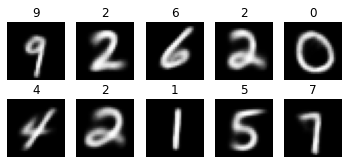

In [17]:
plt.figure()
for i in range(N_SAMPLES):
    ax = plt.subplot(N_SAMPLES // 5 + 1, 5, i + 1)
    plt.imshow(sampled_im_mean[i, :].reshape(28, 28), cmap='gray')
    plt.title(np.argmax(curr_labels[i, :]))
    ax.axis('off')
plt.show()